In [13]:
# imports
import csv
import numpy as np
import pandas as pd
import random as r
import seaborn as sns
import statsmodels.api as SMM
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

In [14]:
# read data from csv files
t0 = pd.read_csv("train_t0.csv") 
t0 = t0.drop(columns=['ID'])
t1 = pd.read_csv("train_t1.csv")
t1 = t1.drop(columns=['ID'])

# read test dataset
test1 = pd.read_csv("test_t0.csv")
test1 = test1.drop(columns=['ID'])

r.seed(1)

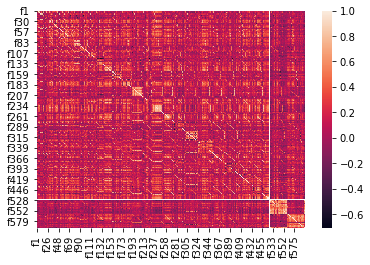

In [23]:
t1_temp = t1 #to keep all t1 values
corr = t0.corr() 
sns.heatmap(corr)

# pairwise correlation 
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        # remove one of the (corr >= 0.9) pairs
        if corr.iloc[i,j] >= 0.9: 
            if columns[j]:
                columns[j] = False
                
# new columns                
selected_columns = t0.columns[columns]
t0 = t0[selected_columns]
t1_temp = t1_temp[selected_columns]
selected_columns = selected_columns[0:].values

In [24]:
# backward elimination
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        Y_temp = Y[:,i]
        x_temp = x[:,i]
        regressor = SMM.OLS(Y_temp, x_temp).fit()
        maxVar = max(regressor.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor.pvalues[j].astype(float) == maxVar):
                    x_temp = np.delete(x_temp, j, 1)
                    x = np.delete(x_temp, j, 1)
                    columns = np.delete(columns, j)                
    regressor.summary()
    return x, columns

SL = 0.05
data_m, selected_columns = backwardElimination(t0.iloc[:,0:].values, t1_temp.iloc[:,0:].values, SL, selected_columns)

t0 = pd.DataFrame(data = data_m, columns = selected_columns)
test1 = pd.DataFrame(data = test1, columns = selected_columns)

In [25]:
def error_func(actual, predicted):
    actual = actual.to_numpy().flatten() #melt t1 dataset (ground truth)
    predicted = predicted.flatten() #melt your prediction
    return mse(predicted,actual) #returns mse result for two melted matrices

In [26]:
# model to predict t1
def model(x,y,test):  
    alphas = 10**np.linspace(10,-2,100)*0.5
    dt = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
    dt.fit(x, y)
    return dt.predict(test)

In [27]:
def findOutliers(X,Y,min_error):
    error_samples = []
    cv_index = 0

    kf = KFold(n_splits=X.shape[0], random_state=r.seed(1), shuffle=False)
    split_indices = kf.split(range(X.shape[0]))

    for train_indices, test_indices in split_indices:
        x_train, y_train = X.iloc[train_indices], Y.iloc[train_indices]
        x_test, y_test = X.iloc[test_indices], Y.iloc[test_indices]
        y_pred = model(x_train, y_train, x_test)
        error = error_func(y_test, y_pred)
        if error>min_error:
            print("CV Fold {}: MSE => {:.5f}%".format(cv_index, error))
            error_samples.append(cv_index)
        cv_index += 1
    return error_samples

In [ ]:
order = findOutliers(t0,t1,0.006)

CV Fold 0: MSE => 0.01720%
CV Fold 14: MSE => 0.00792%
CV Fold 18: MSE => 0.06143%
CV Fold 73: MSE => 0.04536%
CV Fold 98: MSE => 0.00708%


In [ ]:
# cheking the new shapes
print(t0.shape) 
print(test1.shape)

In [ ]:
def removeOutliers(t0,t1,order):
    df0 = pd.DataFrame(t0)
    npdf0 = pd.DataFrame(df0.drop(order).values)
    df1 = pd.DataFrame(t1)
    npdf1 = pd.DataFrame(df1.drop(order).values)
    return npdf0,npdf1

In [ ]:
order = order[::-1] # reversing the array to prevent the indexing error

# removing the outliers
t0, t1 = removeOutliers(t0,t1,order)

# cheking the new shapes
print(t0.shape)
print(t1.shape)

In [ ]:
# Kfold

errors = []
X = t0
Y = t1
cv_index = 1

kf = KFold(n_splits=5, random_state=r.seed(1), shuffle=True)
split_indices = kf.split(range(X.shape[0]))

for train_indices, test_indices in split_indices:
    x_train, y_train = X.iloc[train_indices], Y.iloc[train_indices]
    x_test, y_test = X.iloc[test_indices], Y.iloc[test_indices]
    y_pred = model(x_train, y_train, x_test)
    error = error_func(y_test, y_pred)
    errors.append(error)
    cv_index += 1

In [ ]:
# output

# 1 MSE
print("Average MSE => {:.5f}%".format(sum(errors) / 5))

# 2 y_pred 
y_pred = model(t0, t1, test1)
meltedDF = y_pred.flatten()

In [ ]:
# csv write

f = open('prediction.csv', 'w', newline='')

with f:
    writer = csv.writer(f)
    writer.writerow(['ID','predicted'])
    for i in range(47600):
        writer.writerow([i,meltedDF[i]])